# Data Processing Of MCMC Simulation Data from Binary Alloy

The main objective of this notebook is to document and illustrate all data analysis for determination of critical temperatures and graphics generation for my Theoretical Investigations Project. I have already determined mean field critical curves for the BEG model, and in this notebook I set out to:

1. Produce Order Parameter profiles for several values of vancy and atom chemical potential difference.
1. Compute critical temperatures for several Lattice sizes and vacancy - atom chemical potential difference.
1. Use finite size scaling to determine a set of critical points in $h - T$ phase space projection.

In [1]:
# Imports for clarity
import numpy as np
import random as rd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import time
from scipy.optimize import curve_fit
import pandas as pd
# Import of the module I wrote for MCMC Simulation
import IsingModel as Alloy
plt.style.use('FigureStyle/PaperStyle.mplstyle')

## Order Parameter Profiles for Different Lattice Sizes and Chemical Potential Differences

Remember that the sampled Hamiltonian corresponds to a ferromagnetic BEG Model, on a centered rectangular lattice, with a non-zero quadrtupolar anisotropy term, in the presence of an staggered external magnetic field:

$$H = -\frac{J}{2} \sum\limits_{\langle i_{A_2}, j_{B_2}\rangle} S_{i_{A_2}} S_{j_{B_2}} + \mu\sum\limits_{i} S_i^2 + h\sum\limits_{i_B} S_{i_B} - h\sum\limits_{i_A} S_{i_A}$$

I used conventional MCMC (Markov Chain Monte Carlo) to sample the Gibbs-Boltzman distribution corresponding to this system. Just to remember, the system under study is a bipartite, substitutional, non-stoichiometric, binary alloy. I used MCMC techniques to compute equilibrium values of order parameter:

$$m = \langle S_{i_{A_2}} \rangle + \langle S_{i_{B_2}}\rangle$$

I know that order parameter profile depends not only on temperature, but also on lattice size. Therefore, I computed several datasets corresponding to different values of $\mu$, $h$, temperature ($T$) and lattice size ($L$). I normalised unit energies so that $J = 1$, and units of entropy so that Boltzman's constant, $k_B = 1$.

Each dataset corresponds to magnetisation for 30 equaly spaced temperatures between $T_{\text{min}}=0.05$ and $T_{\text{max}} = 3.5$. I computed magnetisation profiles for values $\mu = 0.0, -1.7$ and $h = 0.0, 0.1, 0.3, 0.5$. Datasets correpsonds to lattice sizes $L = 8, 16, 32, 55$. The dataset files are saved as csv, and the names are **AltL_Mags_mu_h.csv**, in accordance to the following convention:

| Index | $L$ | $\mu$ | $h$ |
|:-----:|:---:|:-----:|:---:|
|  $0$  | $55$|  $0$  |$0.0$|
|  $1$  | $8$ | $-1.7$|$0.1$|
|  $2$  | $16$|   -   |$0.3$|
|  $3$  | $32$|   -   |$0.5$|

**Important:** MCMC Simulations consisted on 15000 steps, with 5000 spare steps.

In [2]:
# Define keys for plotting
Lkey = [55,8,16,32]
Mukey = [0,-1.7]
hkey = [0.0,0.1,0.3,0.5]

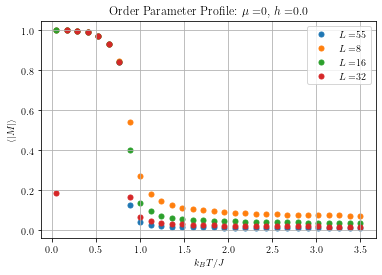

In [39]:
# Read all data files corresponding to indexes following table above and store data for plotting
Muidx = '0'
hidx = '0'
save_ = False 
for i in range(4):
    # Reading with pandas
    filepath = 'Data/Alt'+str(i)+'_'+'Mags_'+Muidx+'_'+hidx+'.csv'
    dataset = pd.read_csv(filepath)
    # Generate scatter plot
    plt.scatter(dataset['Temps'],dataset['Mags'],label=r'$L=$'+str(Lkey[i]))
plt.xlabel(r'$k_BT/J$')
plt.ylabel(r'$\langle |M| \rangle$')
plt.title(r'Order Parameter Profile: '+r'$\mu=$'+str(Mukey[int(Muidx)])+r', $h=$'+str(hkey[int(hidx)]))
plt.legend()
if save_:
    plt.savefig('Figures/'+'MagsProf_'+Muidx+'_'+hidx+'.pdf')
    plt.savefig('Figures/'+'MagsProf_'+Muidx+'_'+hidx+'.png')
plt.show()

In the above cell, a quick overview of the datasets simulated via MCMC can be obtained. A quite unexpected magnetisation profile was obtained when $h > 0$. Although the curve seems to have a critical point, lattice size does not seem to affect the equilibrium magnetisation. This is rather weird, since at a critical point, correlation length diverges, and the finitness of the system should affect the magnetisation profile. As is evident from the Hamiltonian, the value of $\mu$, which is related to vacancy concentration, is not resposible for this behavior. The presence of a non-zero staggered field causes a a non-zero order parameter even at high temperatures. This is readily seen from a magnetic interpretation of the interaction Hamiltonian. Also, remembering that the order parameter is also related to atom concentration difference, this can be intuited.

**Conjecture:** It might be possible that for high staggered field magnitude, this phenomenon competes strongly with the inherent lattice site correlation, thus diminishing significantly the dependence of the order parameter profile with lattice size.

## Computation of critical temperatures

I compute critical temperatures by interpolating order parameter data, and computing the inflection point. Although my simulations showed rather strange profiles for non stoichiometric alloys, the still present an inflection point, which I will use to estimate critical temperature. I will, however, use finte size scaling to determine the actual critical temperature of a stoichiometric binary alloy for the values of $\mu$ considered.

In [53]:
# Interpolation Function
def magsFit(x,A,B,C,D):
    return D*np.tanh(A-B*x)+C

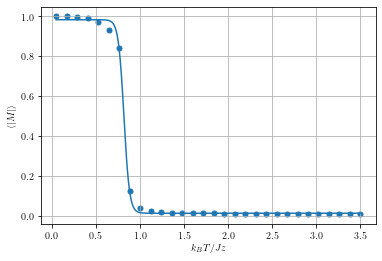

In [62]:
# Read dataset
Muidx = '0'
hidx = '0'
Lidx = '0'
# Reading with pandas
filepath = 'Data/Alt'+Lidx+'_'+'Mags_'+Muidx+'_'+hidx+'.csv'
dataset = pd.read_csv(filepath)
# Interpolate using scipy
fitparams, covmat = curve_fit(\
        MagsFit,dataset['Temps'],dataset['Mags'],\
        bounds=(0,[50.0,50.0,50.0,50.0]))
# Plot Interpolation and dataset
x = np.linspace(0.05,3.5,num=300)
y = magsFit(x,*fitparams)
plt.scatter(dataset['Temps'],dataset['Mags'])
plt.plot(x,y)
plt.xlabel(r'$k_BT/Jz$')
plt.ylabel(r'$\langle |M| \rangle$')
plt.show()

In [56]:
print(fitparams)

[13.00379215 15.88291385  0.49914826  0.48450023]
